Import libraries


In [23]:
# Analysis modules
import sys
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.dates import date2num
import matplotlib.dates as mdates


### Load data


In [24]:
path_to_data  = '../../data/OriginalData.csv'
data = pd.read_csv(path_to_data)

print(data.info())

print('\nKEYS\n----')
for i in data.keys():
    print(i)
print()

display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15748 entries, 0 to 15747
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Dates                             15748 non-null  object 
 1   symbol                            15748 non-null  object 
 2   PX_LAST                           15748 non-null  float64
 3   Dividend_Per_Share                15748 non-null  float64
 4   TOTAL_EQUITY                      15748 non-null  float64
 5   CUR_MKT_CAP                       15748 non-null  float64
 6   gics_sector_name                  15748 non-null  object 
 7   gics_sub_industry_name            15748 non-null  object 
 8   gics_industry_name                15748 non-null  object 
 9   gics_industry_group_name          15748 non-null  object 
 10  gics_industry                     15748 non-null  int64  
 11  gics_sector                       15748 non-null  int64  
 12  Year

,Dates,symbol,PX_LAST,Dividend_Per_Share,TOTAL_EQUITY,CUR_MKT_CAP,gics_sector_name,gics_sub_industry_name,gics_industry_name,gics_industry_group_name,...,NUM_CEOS_EQUIV_INC_COMP_PD,CEO_TENURE_AS_OF_FY_END,TOT_COMP_AW_TO_CFO_EQUIV,TOT_COMP_AW_TO_COO_EQUIV,TOTAL_BOD_COMPENSATION_AWARDED,TOTAL_BOD_FEES_PAID_IN_CASH,TOTAL_BOD_STOCK_AWARDS_GIVEN,NUMBER_OF_BOD_CHANGES_DURING_FY,DATE_OF_LAST_BOD_CHANGE,NUM_DIR_INC_IN_CMPNSTN_PD
0,2014-04-11,AAPL,18.5580,0.1089,120179.000,463486.4114,Information Technology,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",Technology Hardware & Equipment,...,1,3.7500,18520521.0,0,2638340.0,697500.0,1906645.0,2,2014-07-17,8
1,2014-04-11,AMT,80.5500,0.3200,3701.605,31870.1921,Real Estate,Telecom Tower REITs,Specialized REITs,Equity Real Estate Investment Trusts (REITs),...,1,11.2500,4904866.0,0,1975088.0,775000.0,600071.0,1,2014-12-18,9
2,2014-04-11,AMZN,15.5870,0.0000,10328.000,143440.4076,Consumer Discretionary,Broadline Retail,Broadline Retail,Consumer Discretionary Distribution & Retail,...,1,18.6670,5962307.0,0,797000.0,0.0,797000.0,1,2014-07-31,9
3,2014-04-11,BHP,58.8727,0.0000,82279.000,180544.3056,Materials,Diversified Metals & Mining,Metals & Mining,Materials,...,1,1.1667,4639000.0,0,4695000.0,3617000.0,0.0,1,2014-04-15,13
4,2014-04-11,CAT,101.4500,0.6000,20369.000,64707.0750,Industrials,Construction Machinery & Heavy Transportation ...,Machinery,Capital Goods,...,1,4.5000,5286968.0,0,3206983.0,1714174.0,1375110.0,1,2014-12-31,11


### Produce subset dataframe

In [25]:
# Extract these keys from the original data set to produce a smaller set containing only what we need
relevant_data_keys = ['Dates', 
                 'Year', 
                 'symbol',
                 'PX_LAST', 
                 'gics_sector_name', 
                 'DATE_OF_LAST_EXECUTIVE_CHANGE',
                 'TOT_STK_AWD_GIVEN_TO_CEO_EQUIV',
                 'TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV',
                 'TOT_BONUSES_PAID_TO_CEO_EQUIV',
                 'TOT_N_EQT_INCENT_GVN_TO_CEO_EQ',
                 'COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT']

# Produce a subset dataframe containing only the necessary data
subset_data = data[relevant_data_keys].copy()

# Cast both dates columns to datetime64[ns]
# 'Dates', 'DATE_OF_LAST_EXECUTIVE_CHANGE'
subset_data['Dates'] = pd.to_datetime(subset_data['Dates'])
subset_data['DATE_OF_LAST_EXECUTIVE_CHANGE'] = pd.to_datetime(subset_data['DATE_OF_LAST_EXECUTIVE_CHANGE'])
subset_data['COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT'] = pd.to_datetime(subset_data['COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT'], format='%Y%m%d')

subset_data.info()
subset_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15748 entries, 0 to 15747
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Dates                             15748 non-null  datetime64[ns]
 1   Year                              15748 non-null  int64         
 2   symbol                            15748 non-null  object        
 3   PX_LAST                           15748 non-null  float64       
 4   gics_sector_name                  15748 non-null  object        
 5   DATE_OF_LAST_EXECUTIVE_CHANGE     15748 non-null  datetime64[ns]
 6   TOT_STK_AWD_GIVEN_TO_CEO_EQUIV    15748 non-null  float64       
 7   TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV    15748 non-null  int64         
 8   TOT_BONUSES_PAID_TO_CEO_EQUIV     15748 non-null  int64         
 9   TOT_N_EQT_INCENT_GVN_TO_CEO_EQ    15748 non-null  int64         
 10  COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT  15748 non-nu

,Dates,Year,symbol,PX_LAST,gics_sector_name,DATE_OF_LAST_EXECUTIVE_CHANGE,TOT_STK_AWD_GIVEN_TO_CEO_EQUIV,TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV,TOT_BONUSES_PAID_TO_CEO_EQUIV,TOT_N_EQT_INCENT_GVN_TO_CEO_EQ,COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT
0,2014-04-11,2014,AAPL,18.5580,Information Technology,2014-05-29,0.0,0,0,6700000,2011-01-01
1,2014-04-11,2014,AMT,80.5500,Real Estate,2013-12-31,4500051.0,4500007,0,2574000,2003-10-10
2,2014-04-11,2014,AMZN,15.5870,Consumer Discretionary,2006-04-30,0.0,0,0,0,1996-05-01
3,2014-04-11,2014,BHP,58.8727,Materials,2014-03-03,3338000.0,0,1568000,0,2013-05-10
4,2014-04-11,2014,CAT,101.4500,Industrials,2013-01-01,0.0,8377481,0,4913288,2010-07-01
...,...,...,...,...,...,...,...,...,...,...,...
15743,2023-12-29,2023,UNH,526.4700,Health Care,2022-03-01,15000970.0,5000114,0,1800000,2021-02-04
15744,2023-12-29,2023,V,260.3500,Financials,2023-08-01,28004734.0,10707531,0,10312500,2023-02-01
15745,2023-12-29,2023,WFC,49.2200,Financials,2020-10-01,16634168.0,0,0,6625000,2019-10-21
15746,2023-12-29,2023,WMT,52.5500,Consumer Staples,2022-06-06,30103720.0,0,0,4627582,2019-11-01


In [26]:
print(data['symbol'].unique())

['AAPL' 'AMT' 'AMZN' 'BHP' 'CAT' 'COST' 'CVX' 'DUK' 'EQIX' 'GE' 'HD' 'JPM'
 'LLY' 'META' 'MSFT' 'NEE' 'NFLX' 'NVDA' 'NVO' 'PG' 'PLD' 'RTX' 'SHEL'
 'SHW' 'SO' 'TSLA' 'UNH' 'V' 'WFC' 'WMT' 'XOM']


### Isolate data for processing

In [27]:
# Create mini dataframe viewing just one company
company_df = subset_data[subset_data['symbol'] == 'MSFT'].copy()

display(company_df.info())
display(company_df)

<class 'pandas.core.frame.DataFrame'>
Index: 508 entries, 14 to 15731
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Dates                             508 non-null    datetime64[ns]
 1   Year                              508 non-null    int64         
 2   symbol                            508 non-null    object        
 3   PX_LAST                           508 non-null    float64       
 4   gics_sector_name                  508 non-null    object        
 5   DATE_OF_LAST_EXECUTIVE_CHANGE     508 non-null    datetime64[ns]
 6   TOT_STK_AWD_GIVEN_TO_CEO_EQUIV    508 non-null    float64       
 7   TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV    508 non-null    int64         
 8   TOT_BONUSES_PAID_TO_CEO_EQUIV     508 non-null    int64         
 9   TOT_N_EQT_INCENT_GVN_TO_CEO_EQ    508 non-null    int64         
 10  COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT  508 non-null    da

None

,Dates,Year,symbol,PX_LAST,gics_sector_name,DATE_OF_LAST_EXECUTIVE_CHANGE,TOT_STK_AWD_GIVEN_TO_CEO_EQUIV,TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV,TOT_BONUSES_PAID_TO_CEO_EQUIV,TOT_N_EQT_INCENT_GVN_TO_CEO_EQ,COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT
14,2014-04-11,2014,MSFT,39.209,Information Technology,2014-02-04,79813567.0,0,3600000,0,2014-02-04
45,2014-04-18,2014,MSFT,40.010,Information Technology,2014-02-04,79813567.0,0,3600000,0,2014-02-04
76,2014-04-25,2014,MSFT,39.910,Information Technology,2014-02-04,79813567.0,0,3600000,0,2014-02-04
107,2014-05-02,2014,MSFT,39.690,Information Technology,2014-02-04,79813567.0,0,3600000,0,2014-02-04
138,2014-05-09,2014,MSFT,39.540,Information Technology,2014-02-04,79813567.0,0,3600000,0,2014-02-04
...,...,...,...,...,...,...,...,...,...,...,...
15607,2023-12-01,2023,MSFT,374.510,Information Technology,2021-09-15,39236137.0,0,0,6414750,2014-02-04
15638,2023-12-08,2023,MSFT,374.230,Information Technology,2021-09-15,39236137.0,0,0,6414750,2014-02-04
15669,2023-12-15,2023,MSFT,370.730,Information Technology,2021-09-15,39236137.0,0,0,6414750,2014-02-04
15700,2023-12-22,2023,MSFT,374.580,Information Technology,2021-09-15,39236137.0,0,0,6414750,2014-02-04


### Compute returns
Cash incentive for CEO

Compensation ratio is computed as 
$\frac{Cash}{Cash + Equity}$

where 1.0 denotes 100% cash compensation, and 0.0 denotes 100% equity compensation

In [28]:
# add columns to company_df
company_df.loc[:,"equity_Compensation_CEO"] = company_df['TOT_STK_AWD_GIVEN_TO_CEO_EQUIV']+company_df["TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV"]
company_df.loc[:,"cash_incentive_CEO"] = company_df['TOT_BONUSES_PAID_TO_CEO_EQUIV']+company_df['TOT_N_EQT_INCENT_GVN_TO_CEO_EQ']
company_df.loc[:,"Variable_Pay_CEO"] = company_df["cash_incentive_CEO"]+company_df["equity_Compensation_CEO"]+sys.float_info.min
company_df.loc[:,"cash_incentive_CEO_percent"] = company_df["cash_incentive_CEO"]/company_df["Variable_Pay_CEO"]

display(company_df)

,Dates,Year,symbol,PX_LAST,gics_sector_name,DATE_OF_LAST_EXECUTIVE_CHANGE,TOT_STK_AWD_GIVEN_TO_CEO_EQUIV,TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV,TOT_BONUSES_PAID_TO_CEO_EQUIV,TOT_N_EQT_INCENT_GVN_TO_CEO_EQ,COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT,equity_Compensation_CEO,cash_incentive_CEO,Variable_Pay_CEO,cash_incentive_CEO_percent
14,2014-04-11,2014,MSFT,39.209,Information Technology,2014-02-04,79813567.0,0,3600000,0,2014-02-04,79813567.0,3600000,83413567.0,0.043158
45,2014-04-18,2014,MSFT,40.010,Information Technology,2014-02-04,79813567.0,0,3600000,0,2014-02-04,79813567.0,3600000,83413567.0,0.043158
76,2014-04-25,2014,MSFT,39.910,Information Technology,2014-02-04,79813567.0,0,3600000,0,2014-02-04,79813567.0,3600000,83413567.0,0.043158
107,2014-05-02,2014,MSFT,39.690,Information Technology,2014-02-04,79813567.0,0,3600000,0,2014-02-04,79813567.0,3600000,83413567.0,0.043158
138,2014-05-09,2014,MSFT,39.540,Information Technology,2014-02-04,79813567.0,0,3600000,0,2014-02-04,79813567.0,3600000,83413567.0,0.043158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15607,2023-12-01,2023,MSFT,374.510,Information Technology,2021-09-15,39236137.0,0,0,6414750,2014-02-04,39236137.0,6414750,45650887.0,0.140518
15638,2023-12-08,2023,MSFT,374.230,Information Technology,2021-09-15,39236137.0,0,0,6414750,2014-02-04,39236137.0,6414750,45650887.0,0.140518
15669,2023-12-15,2023,MSFT,370.730,Information Technology,2021-09-15,39236137.0,0,0,6414750,2014-02-04,39236137.0,6414750,45650887.0,0.140518
15700,2023-12-22,2023,MSFT,374.580,Information Technology,2021-09-15,39236137.0,0,0,6414750,2014-02-04,39236137.0,6414750,45650887.0,0.140518


### Plot compensation ratio to returns

In [29]:
# Get weeks count
dates = company_df['Dates'].iloc[1:].to_numpy()
dates = date2num(dates)

# Get Numpy array of weekly returns
weekly_returns = company_df['PX_LAST'].pct_change() * 100
weekly_returns = weekly_returns.dropna()
weekly_returns = weekly_returns.to_numpy()

# Get Numpy array of CEO cash incentive percentages
cash_incentive = company_df['cash_incentive_CEO_percent'].iloc[1:].to_numpy()

# Get Numpy array of date of last CEO change
exec_changes = company_df['COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT'].iloc[1:].to_numpy()
exec_changes = np.unique(exec_changes)

# Assure number of elements line up
print('Dates: ', len(dates), '\nWeekly returns array size: ', len(weekly_returns), '\nCash incentive array size: ', len(cash_incentive), '\nExecutive changes: ', len(exec_changes))

Dates:  507 
Weekly returns array size:  507 
Cash incentive array size:  507 
Executive changes:  1


In [30]:
# Display unique values in incentive ratio column
# In the cell below, ratio changes of threshold 1% are extracted to remove redundant changes 
print('Unique values in cash_incentive column:')
for i in np.unique(cash_incentive):
    print(i)

Unique values in cash_incentive column:
0.043158446874715234
0.14051753255090094
0.19234348172178037
0.25290869884738615
0.263530083282411
0.2668164962866286
0.27090786359230745
0.30080300910948976
0.3064103774612697
0.38081009855275066


In [31]:
# Display the last dates of executive changes
print('Dates of executive changes:')
for i in exec_changes:
    print(i)

Dates of executive changes:
2014-02-04T00:00:00.000000000


### Plot returns over time

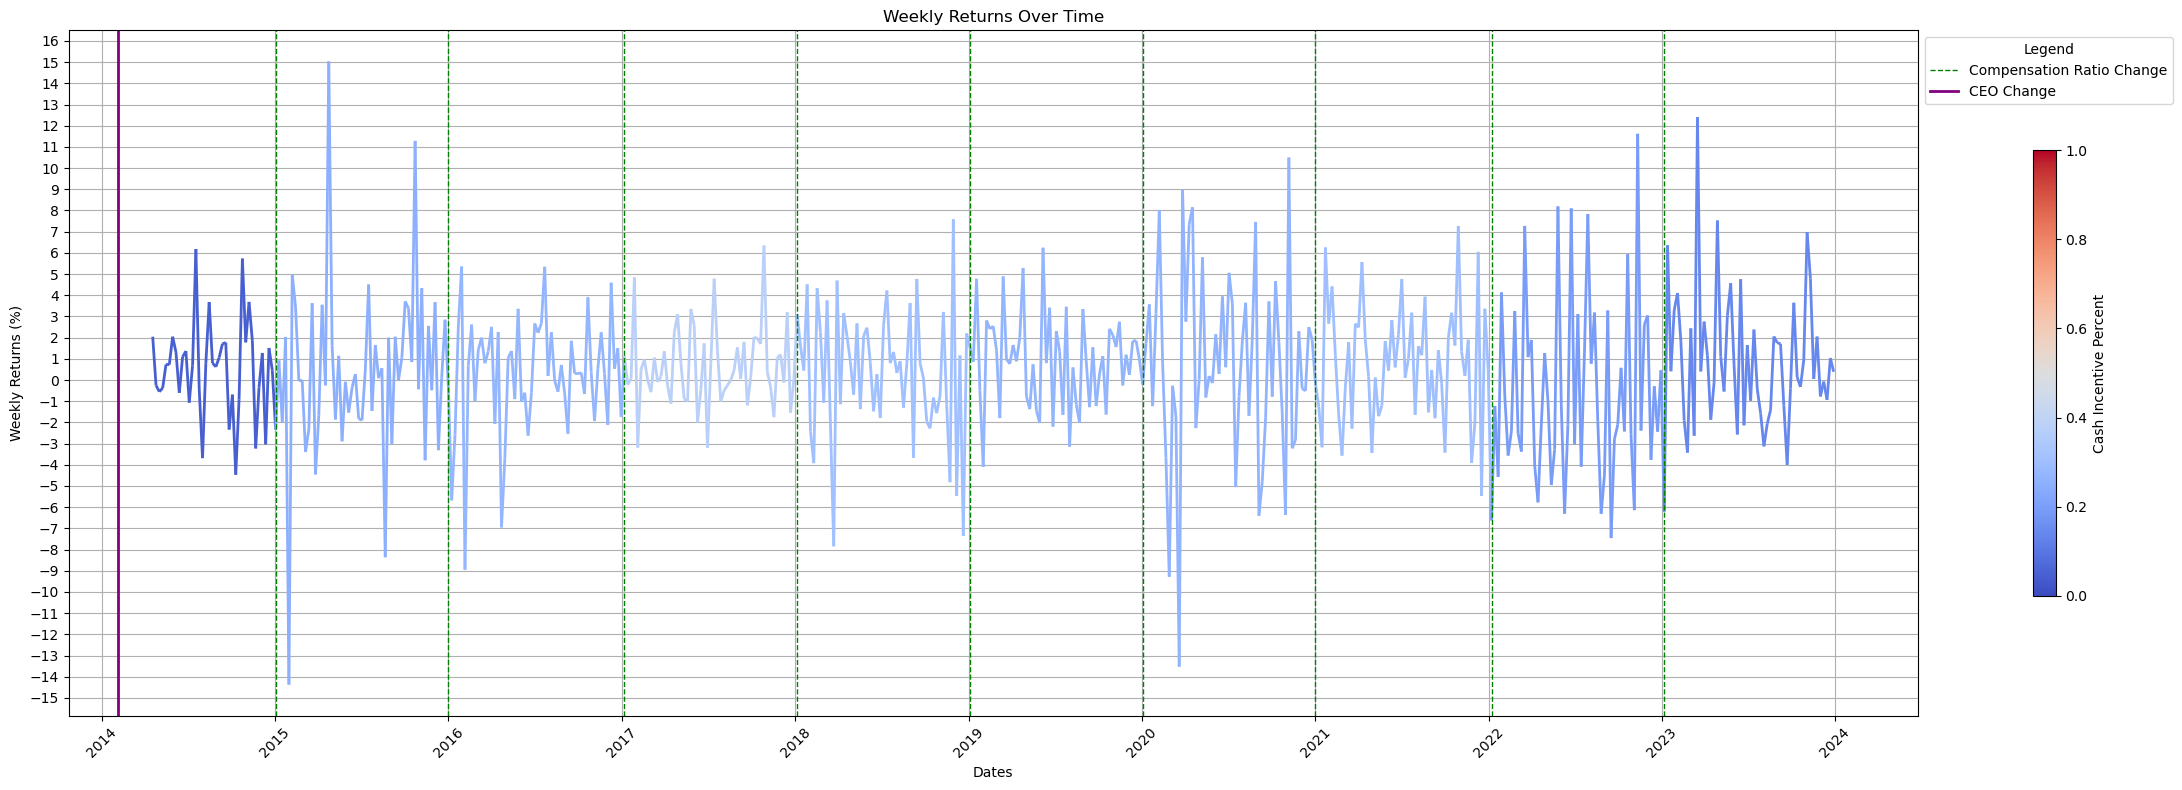

In [36]:
# Plot setup
plt.figure(figsize=(24, 8))  # Set figure size for better visualization

# Normalize the cash incentive percent to use as a gradient
norm = Normalize(vmin=0, vmax=1)  # Dynamically adjust normalization
cmap = 'coolwarm'  # Choose the colormap for line coloring

# 1. Calculate the dates when the cash incentive ratio changes significantly (more than the threshold)

threshold = 0.01                                                # 1% threshold to detect significant changes in incentive
diff = np.diff(cash_incentive)                                  # Calculate the difference between consecutive values
relative_change = np.abs(diff) / cash_incentive[:-1]            # Calculate the relative change (percent change)
change_indices = np.where(relative_change > threshold)[0] + 1   # Get the indices where change exceeds the threshold
change_dates = dates[change_indices]                            # Extract the corresponding dates for these changes


# 2. Ensure the cash_incentive array matches the length of dates for plotting
if len(cash_incentive) == len(dates):
    cash_incentive = cash_incentive[:-1]                        # Adjust the length of cash_incentive if needed

# 3. Create a list of line segments for plotting the weekly returnsCOMP_LKD_LAST_CEO_&_EQUIV_CHG_DT'
segments = [
    [(dates[i - 1], weekly_returns[i - 1]), (dates[i], weekly_returns[i])]
    for i in range(1, len(dates))
]


# 4. Create a LineCollection for the line segments, using the cash_incentive array for coloring
line_segments = LineCollection(
    segments, cmap=cmap, norm=norm, array=cash_incentive, linewidth=2
)


# 5. Plot the line segments on the graph
ax = plt.gca()                                                  # Get the current axis to add elements
ax.add_collection(line_segments)                                # Add the line segments to the plot
ax.autoscale()                                                  # Rescale axes to ensure the line collection fits


# 6. Plot vertical lines for the significant cash incentive changes
for change_date in change_dates:
    ax.axvline(change_date, color='green', linestyle='--', linewidth=1, label='Compensation Ratio Change')

# 7. Plot vertical lines for the executive change dates
for change_date in exec_changes:
    ax.axvline(change_date, color='purple', linestyle='-', linewidth=2, label='CEO Change')

# 8. Add a color bar to show the scale of cash incentive percent
cbar = plt.colorbar(line_segments, shrink=0.65)
cbar.set_label("Cash Incentive Percent")

# 9. Format the x-axis to show years and automatically adjust date ticks

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     # Display years on the x-axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())         # Automatically set the date intervals

# 10. Customize labels and titles
plt.xlabel("Dates")                                          # Set the x-axis label
plt.ylabel("Weekly Returns (%)")                             # Set the y-axis label
plt.title("Weekly Returns Over Time")                        # Set the title of the plot

# 11. Adjust x-tick labels and y-ticks
plt.xticks(rotation=45)                                      # Rotate x-axis labels for readability
tick_step = 1.0                                              # Adjust for finer control over steps on the y-axis

y_ticks = np.arange(np.floor(min(weekly_returns) / tick_step) * tick_step, 
                    np.ceil(max(weekly_returns) / tick_step) * tick_step + tick_step, 
                    tick_step)
plt.yticks(y_ticks)

# 12. Add grid for better readability
plt.grid()

# 13. Add legend to the plot
# Remove duplicate entries from the legend
handles, labels = ax.get_legend_handles_labels()
# Use a dictionary to eliminate duplicates (labels are keys)
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', bbox_to_anchor=(1, 1), title='Legend')


# 14. Adjust layout to ensure everything fits
plt.tight_layout()

# 15. Show the plot
plt.show()

### Plot Share Price over time

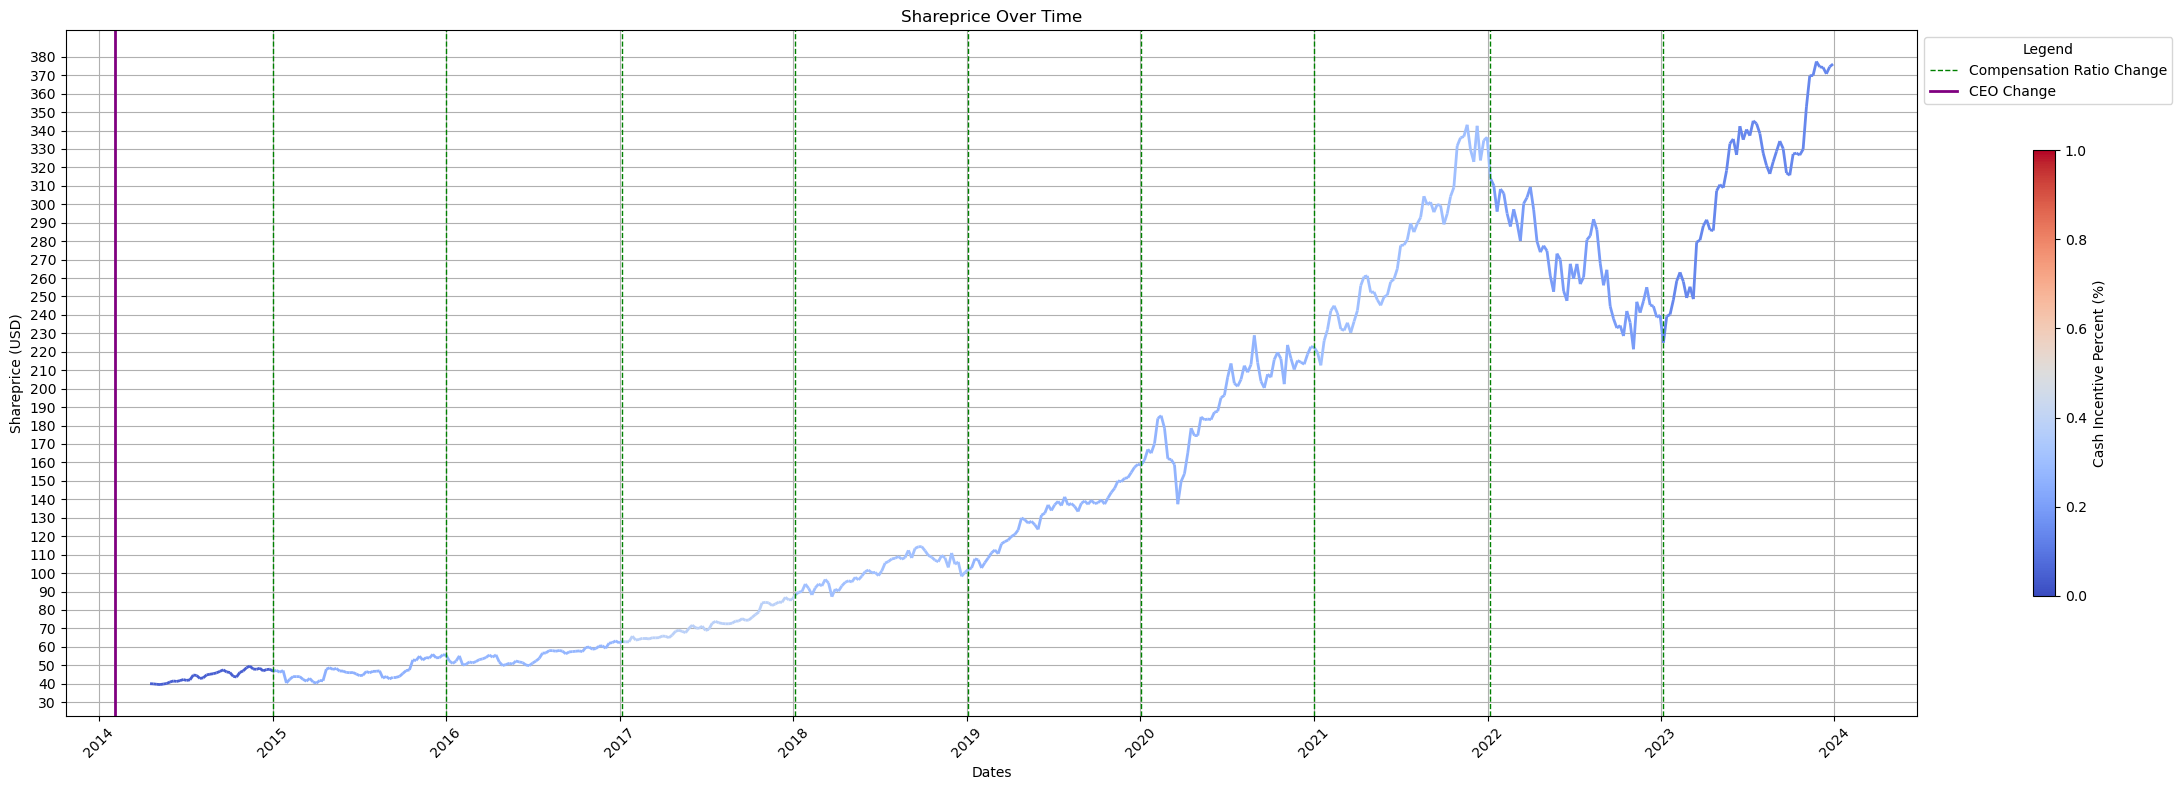

In [35]:
share_price = company_df['PX_LAST'].iloc[1:]
share_price = share_price.to_numpy()

# Plot setup
plt.figure(figsize=(24, 8))  # Set figure size for better visualization

# Normalize the cash incentive percent to use as a gradient
norm = Normalize(vmin=0, vmax=1)  # Dynamically adjust normalization
cmap = 'coolwarm'  # Choose the colormap for line coloring

# 1. Calculate the dates when the cash incentive ratio changes significantly (more than the threshold)
threshold = 0.01  # 1% threshold to detect significant changes in incentive
diff = np.diff(cash_incentive)  # Calculate the difference between consecutive values
relative_change = np.abs(diff) / cash_incentive[:-1]  # Calculate the relative change (percent change)
change_indices = np.where(relative_change > threshold)[0] + 1  # Get the indices where change exceeds the threshold
change_dates = dates[change_indices]  # Extract the corresponding dates for these changes

# 2. Ensure the cash_incentive array matches the length of dates for plotting
if len(cash_incentive) == len(dates):
    cash_incentive = cash_incentive[:-1]  # Adjust the length of cash_incentive if needed

# 3. Create a list of line segments for plotting the weekly returns
segments = [
    [(dates[i - 1], share_price[i - 1]), (dates[i], share_price[i])]
    for i in range(1, len(dates))
]

# 4. Create a LineCollection for the line segments, using the cash_incentive array for coloring
line_segments = LineCollection(
    segments, cmap=cmap, norm=norm, array=cash_incentive, linewidth=2
)

# 5. Plot the line segments on the graph
ax = plt.gca()  # Get the current axis to add elements
ax.add_collection(line_segments)  # Add the line segments to the plot
ax.autoscale()  # Rescale axes to ensure the line collection fits

# 6. Plot vertical lines for the significant cash incentive changes
for change_date in change_dates:
    ax.axvline(change_date, color='green', linestyle='--', linewidth=1, label='Compensation Ratio Change')

# 7. Plot vertical lines for the executive change dates
for change_date in exec_changes:
    ax.axvline(change_date, color='purple', linestyle='-', linewidth=2, label='CEO Change')

# 8. Add a color bar to show the scale of cash incentive percent
cbar = plt.colorbar(line_segments, shrink=0.65)
cbar.set_label("Cash Incentive Percent (%)")

# 9. Format the x-axis to show years and automatically adjust date ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display years on the x-axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically set the date intervals

# 10. Customize labels and titles
plt.xlabel("Dates")  # Set the x-axis label
plt.ylabel("Shareprice (USD)")  # Set the y-axis label
plt.title("Shareprice Over Time")  # Set the title of the plot

# 11. Adjust x-tick labels and y-ticks
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
tick_step = 10  # Adjust for finer control over steps on the y-axis
y_ticks = np.arange(np.floor(min(share_price) / tick_step) * tick_step, 
                    np.ceil(max(share_price) / tick_step) * tick_step + tick_step, 
                    tick_step)
plt.yticks(y_ticks)

# 12. Add grid for better readability
plt.grid()

# 13. Add legend to the plot
# Remove duplicate entries from the legend
handles, labels = ax.get_legend_handles_labels()
# Use a dictionary to eliminate duplicates (labels are keys)
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', bbox_to_anchor=(1, 1), title='Legend')


# 14. Adjust layout to ensure everything fits
plt.tight_layout()

# 15. Show the plot
plt.show()

### Wrap data plotting into a function
